In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
import pandas as pd
from tensorflow import keras
from utils.helper import (
    folder_to_sequence,
    MinMaxScaler_AE,
)

import sys
sys.path.append("../")
from train_model import PARAMETERS

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

2025-04-20 15:42:42.494562: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# carregando os dados para a memória
DEFAULT_WS = PARAMETERS["window_size"]
Xnormal, Ynormal = folder_to_sequence("VIDRO-B3", DEFAULT_WS)

anomalies_data = [
    folder_to_sequence("ANOMALIAS/B3+200g", DEFAULT_WS),
    folder_to_sequence("ANOMALIAS/B3-200g", DEFAULT_WS),
    folder_to_sequence("PAINCO", DEFAULT_WS),
    folder_to_sequence("VIDRO-B2", DEFAULT_WS),
]

Xanomalies = [data[0] for data in anomalies_data]
Yanomalies = [data[1] for data in anomalies_data]

Xtransient, Ytransient = folder_to_sequence("ANOMALIAS/Transiente", DEFAULT_WS)

100%|██████████| 1/1 [00:00<00:00, 36.47it/s]


Text(0, 0.5, '$-(\\Delta P_N)$ - [PT105]')

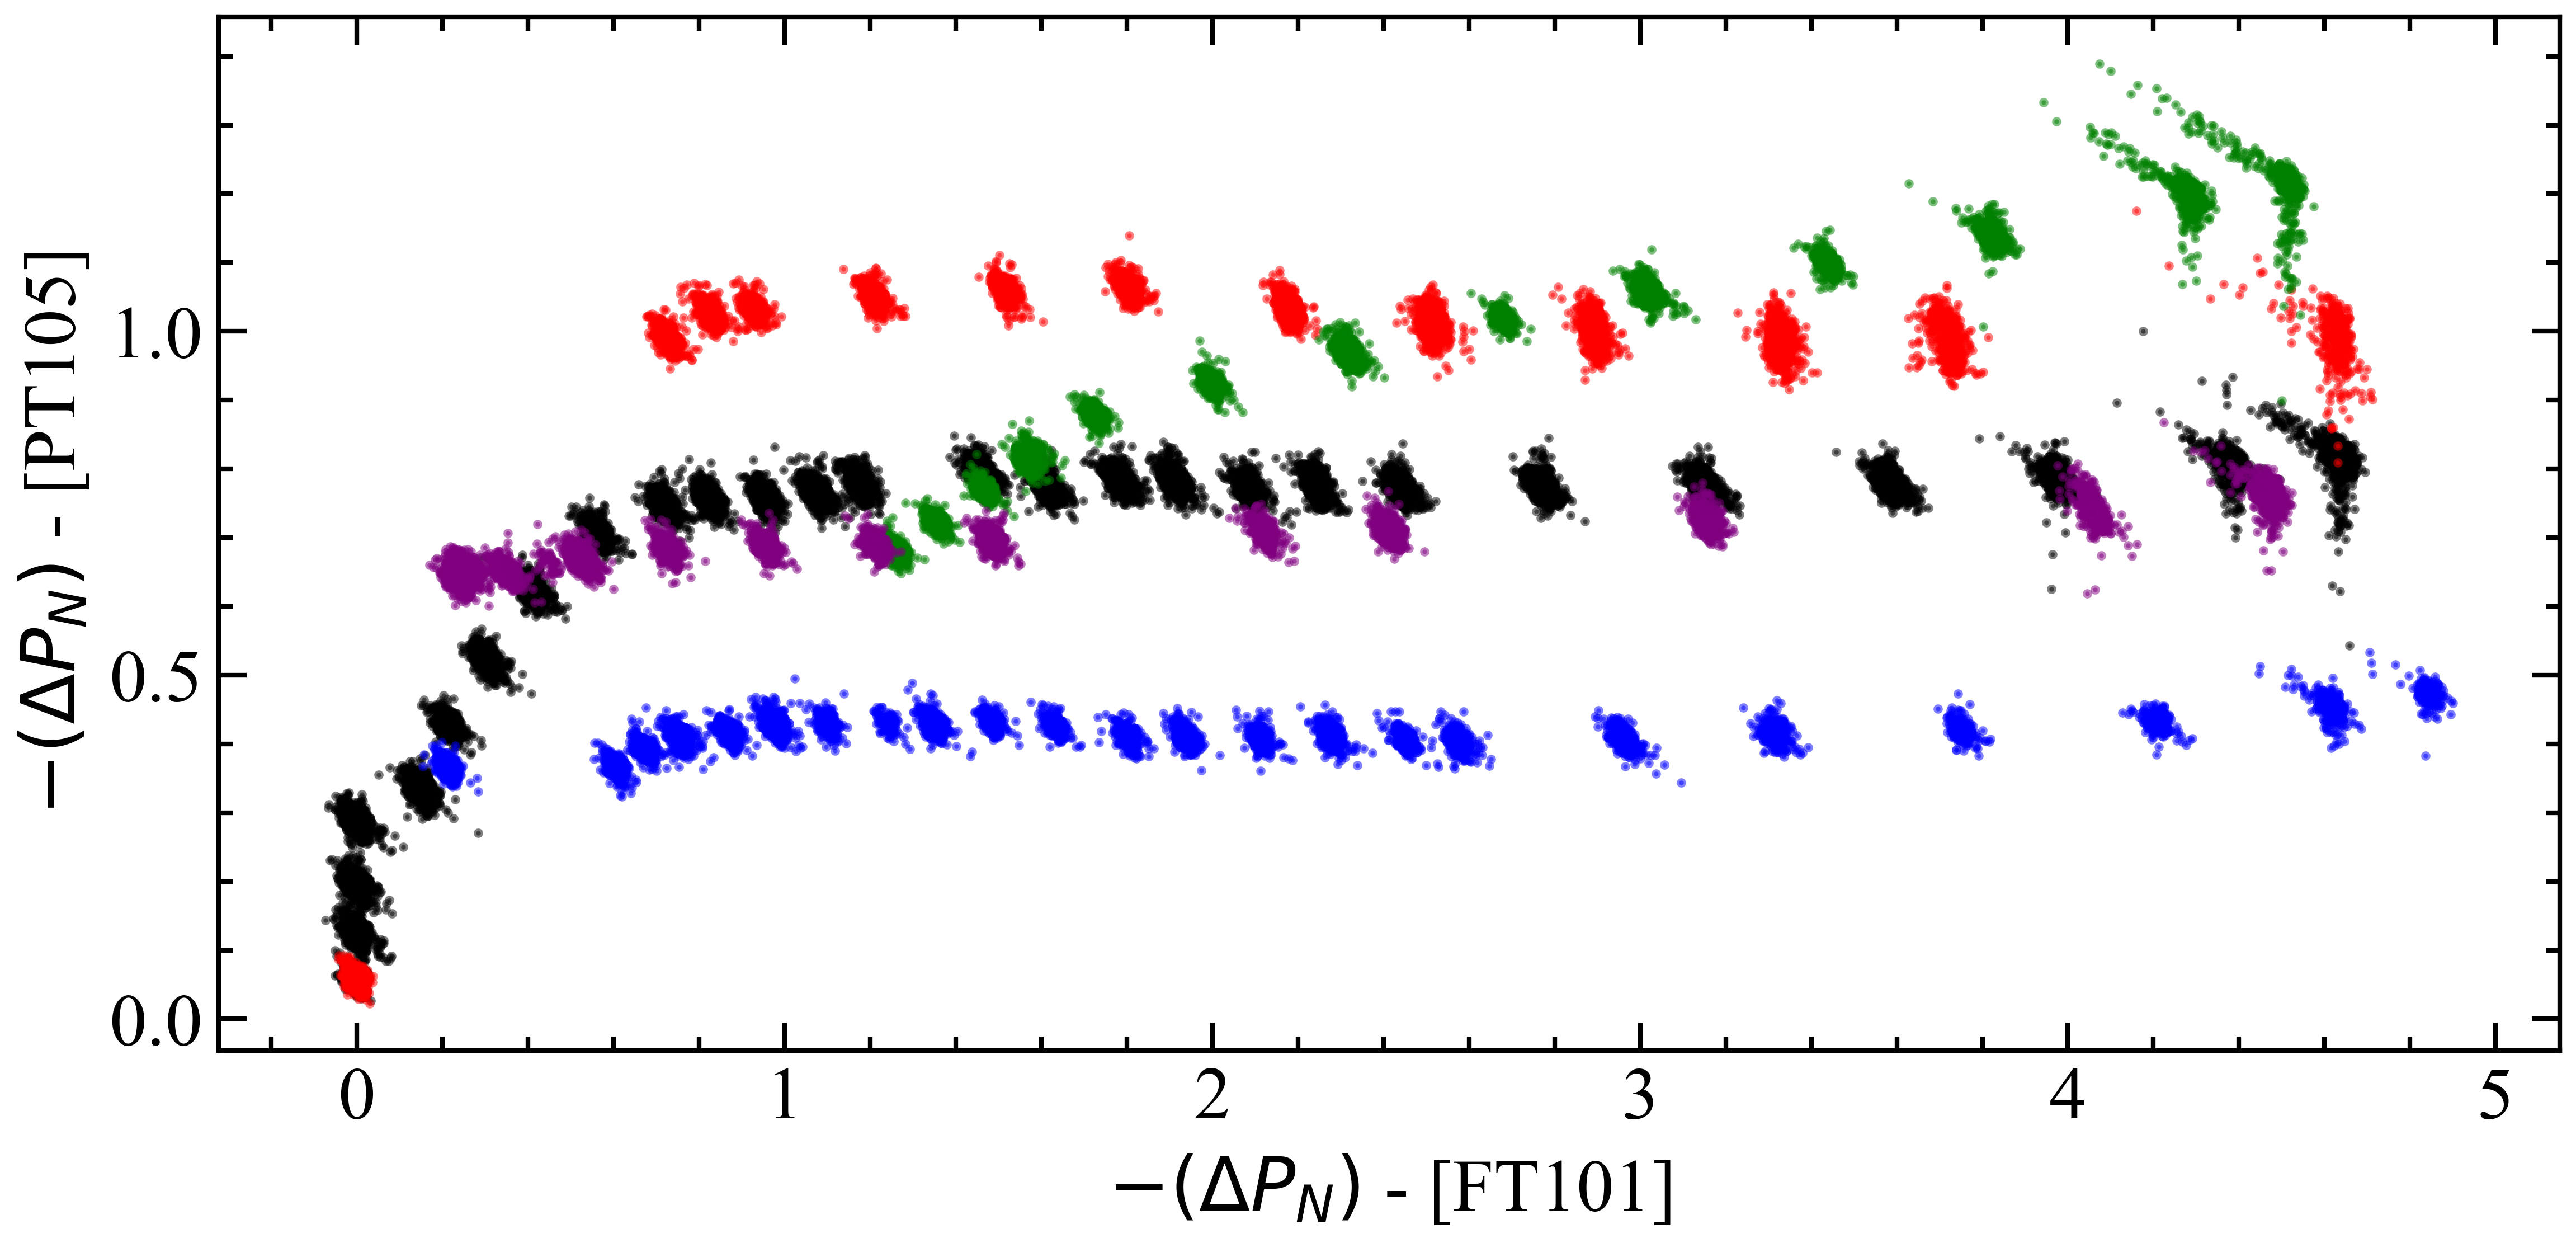

In [3]:
plt.scatter(Xnormal[:, 0, 0], Ynormal[:, 0, 0], label="Normal", s=1, alpha=0.5)

plt.scatter(Xanomalies[0][:, 0, 0], Yanomalies[0][:, 0, 0], label="Anomaly 1", s=1, alpha=0.5, c="r")
plt.scatter(Xanomalies[1][:, 0, 0], Yanomalies[1][:, 0, 0], label="Anomaly 2", s=1, alpha=0.5, c="b")
plt.scatter(Xanomalies[2][:, 0, 0], Yanomalies[2][:, 0, 0], label="Anomaly 2", s=1, alpha=0.5, c="g")
plt.scatter(Xanomalies[3][:, 0, 0], Yanomalies[3][:, 0, 0], label="Anomaly 2", s=1, alpha=0.5, c="purple")


plt.xlabel(r"$-(\Delta P_N)$ - [FT101]")
plt.ylabel(r"$-(\Delta P_N)$ - [PT105]")

In [4]:
Xscaler = MinMaxScaler_AE()
Yscaler = MinMaxScaler_AE()

Xscaler.fit(Xnormal)
Yscaler.fit(Ynormal)

# Xanomalies = [Xscaler.transform(data) for data in Xanomalies]
# Yanomalies = [Yscaler.transform(data) for data in Yanomalies]

seq2seq = keras.models.load_model("../models/best_model.keras")

In [5]:
# 1) Analisar os erros no conjunto de treino


def get_error_dist(Xdata: np.ndarray, Ydata: np.ndarray) -> np.ndarray:
    xnorm = Xscaler.transform(Xdata)
    ypred = seq2seq.predict(xnorm)

    ynorm = Yscaler.transform(Ydata)

    ynorm_squeezed = ynorm.squeeze(axis=-1)
    ypred_squeezed = ypred

    print(f"ynorm shape: {ynorm_squeezed.shape}")
    print(f"ypred shape: {ypred.shape}")

    # Garante que as formas são compatíveis para subtração
    if ynorm_squeezed.shape != ypred_squeezed.shape:
         # Tenta ajustar se a diferença for apenas na dimensão da janela
         min_len = min(ynorm_squeezed.shape[1], ypred_squeezed.shape[1])
         errors = np.mean(np.abs(ynorm_squeezed[:, :min_len] - ypred_squeezed[:, :min_len]), axis=1)
         print(f"Warning: Shape mismatch in get_error_dist ({ynorm_squeezed.shape} vs {ypred_squeezed.shape}). Comparing up to minimum length ({min_len}).")
    else:
         # Calcula o erro médio absoluto entre Y normalizado e Y previsto por janela
         errors = np.mean(np.abs(ynorm_squeezed - ypred_squeezed), axis=1)

    return errors


def plot_error_dist(
    error_dist: np.ndarray,
    threshold: float,
    color: str,
    cumulative=False,
):
    fig, ax = plt.subplots()
    ax.grid()
    sns.histplot(
        error_dist,
        kde=True,
        bins=50,
        color=color,
        stat="percent",
        ax=ax,
        cumulative=cumulative,
    )
    ax.set_ylabel(r"Porcentagem (%)")
    ax.set_xlabel("Erro médio absoluto")
    ax.axvline(threshold, color="black", linestyle="--", label="Limiar")
    ax.legend()
    ax.legend(title=f"Janela > Limiar: {get_accuracy(error_dist, threshold) * 100:.2f}%")
    return ax

def plot_anomalies(
    Ydata: np.ndarray,
    errors: np.ndarray,
    max_error: float,
    ax: plt.Axes = None,
):
    anomaly_points = np.where(errors > max_error)[0]

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    time_idx = np.arange(len(Ydata))
    ax.plot(time_idx, Ydata[:, 0, 0], label="Sinal Original (Y)")

    if len(anomaly_points) > 0:
        ax.scatter(
            time_idx[anomaly_points],
            Ydata[anomaly_points, 0, 0],
            c="r",
            label="Pontos Anômalos"
        )

    ax.set_ylabel(r"$(-\Delta$P$_N)$")

    return fig, ax

def get_accuracy(errors: np.ndarray, threshold: float) -> float:
    anomalies = errors > threshold
    accuracy: float = np.mean(anomalies)
    return accuracy

In [6]:
normal_err = get_error_dist(Xnormal, Ynormal)
threshold = np.percentile(normal_err, 95)

1033/1033 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step
ynorm shape: (33031, 20)
ypred shape: (33031, 20)


Text(0.5, 0, 'Instante')

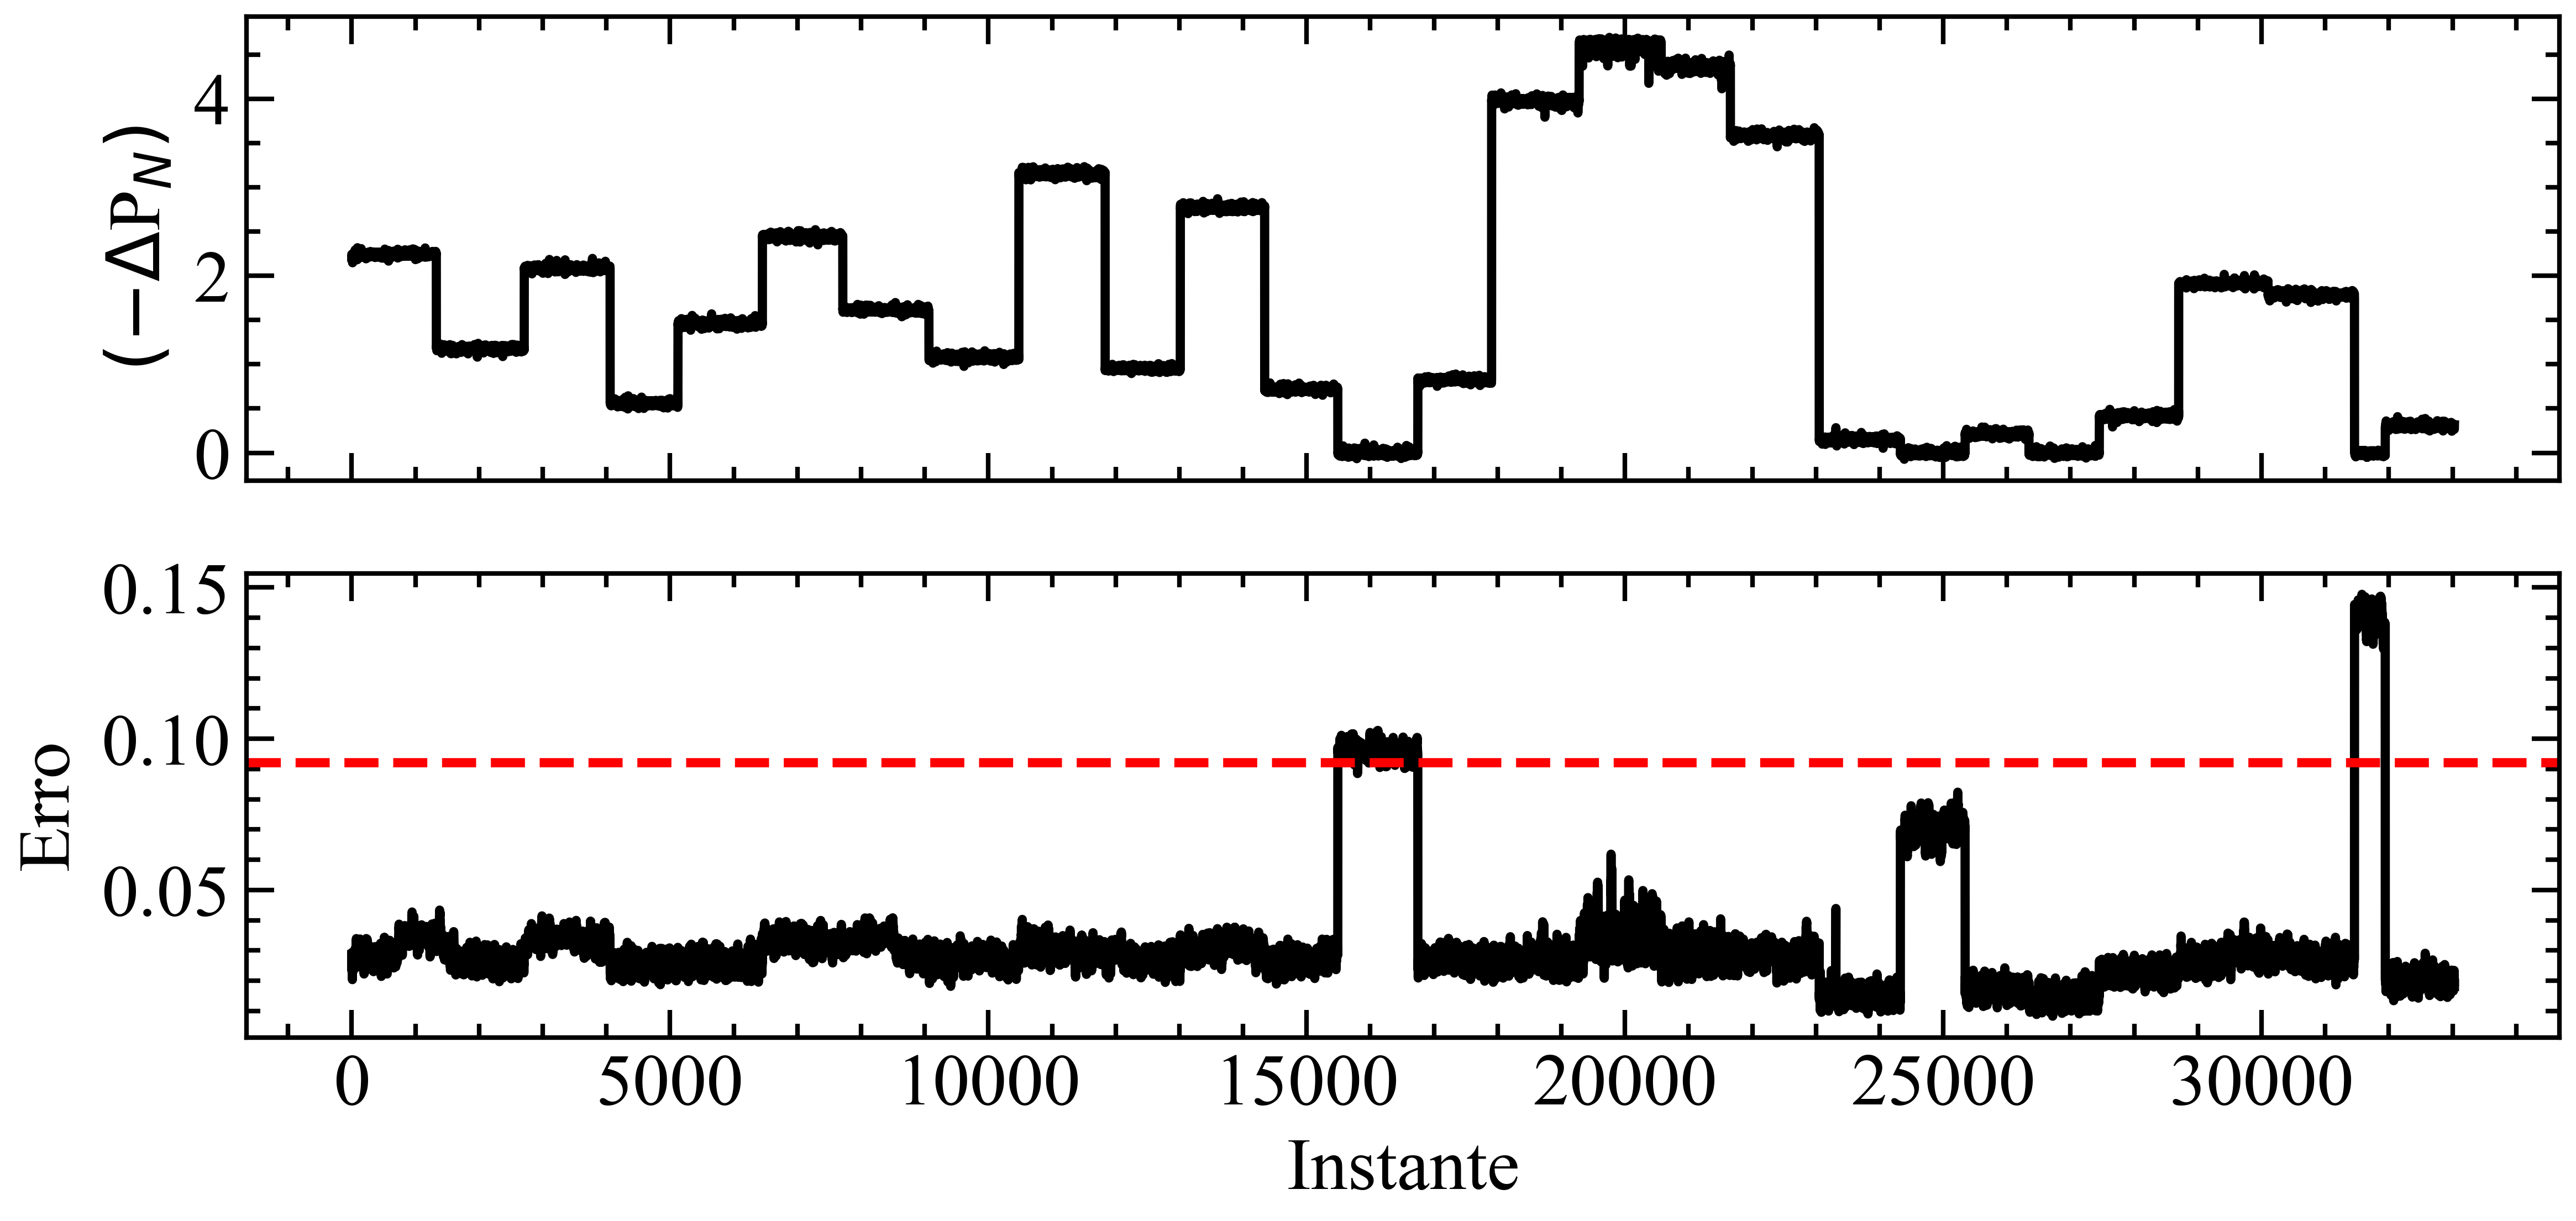

In [7]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(Xnormal[:, 0, 0], label="Dados")
ax[0].set_ylabel(r"$(-\Delta$P$_N)$")

ax[1].set_ylabel("Erro")
ax[1].plot(normal_err, label="Erro")

ax[1].axhline(threshold, color="red", linestyle="--", label="Limiar")
ax[1].set_xlabel("Instante")

<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

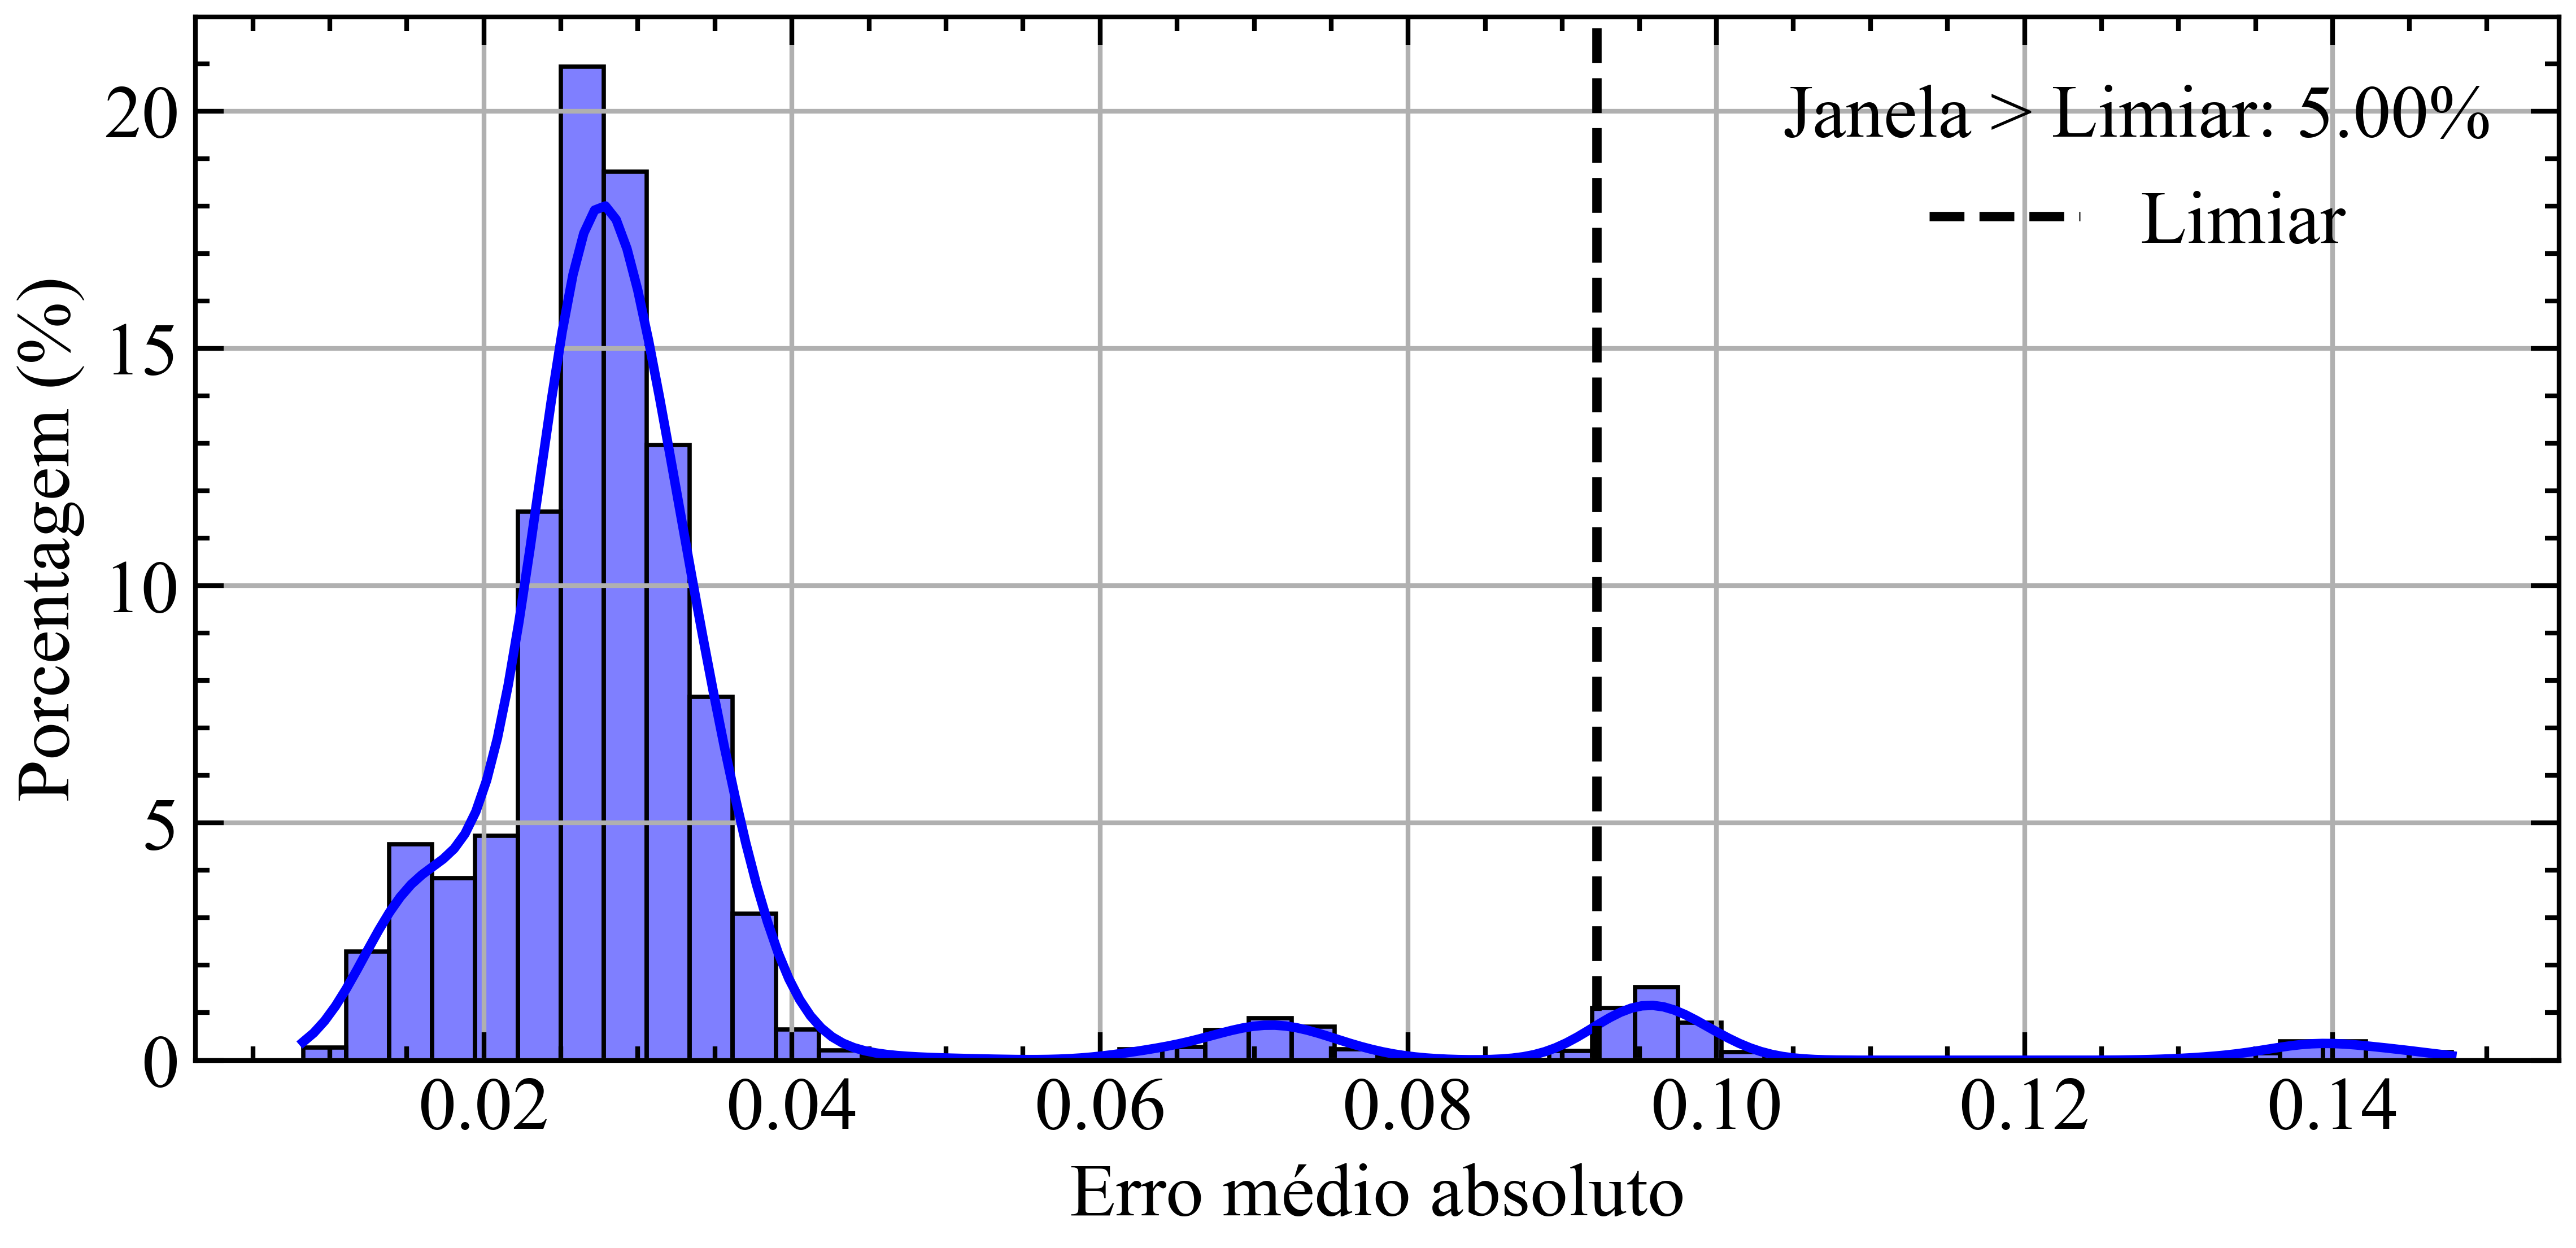

In [8]:
plot_error_dist(normal_err, threshold, "blue")

In [9]:
errors = [get_error_dist(xanomaly, yanomaly) for xanomaly, yanomaly in zip(Xanomalies, Yanomalies)]

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
ynorm shape: (8985, 20)
ypred shape: (8985, 20)
271/271 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
ynorm shape: (8665, 20)
ypred shape: (8665, 20)
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
ynorm shape: (7159, 20)
ypred shape: (7159, 20)
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
ynorm shape: (7603, 20)
ypred shape: (7603, 20)


<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

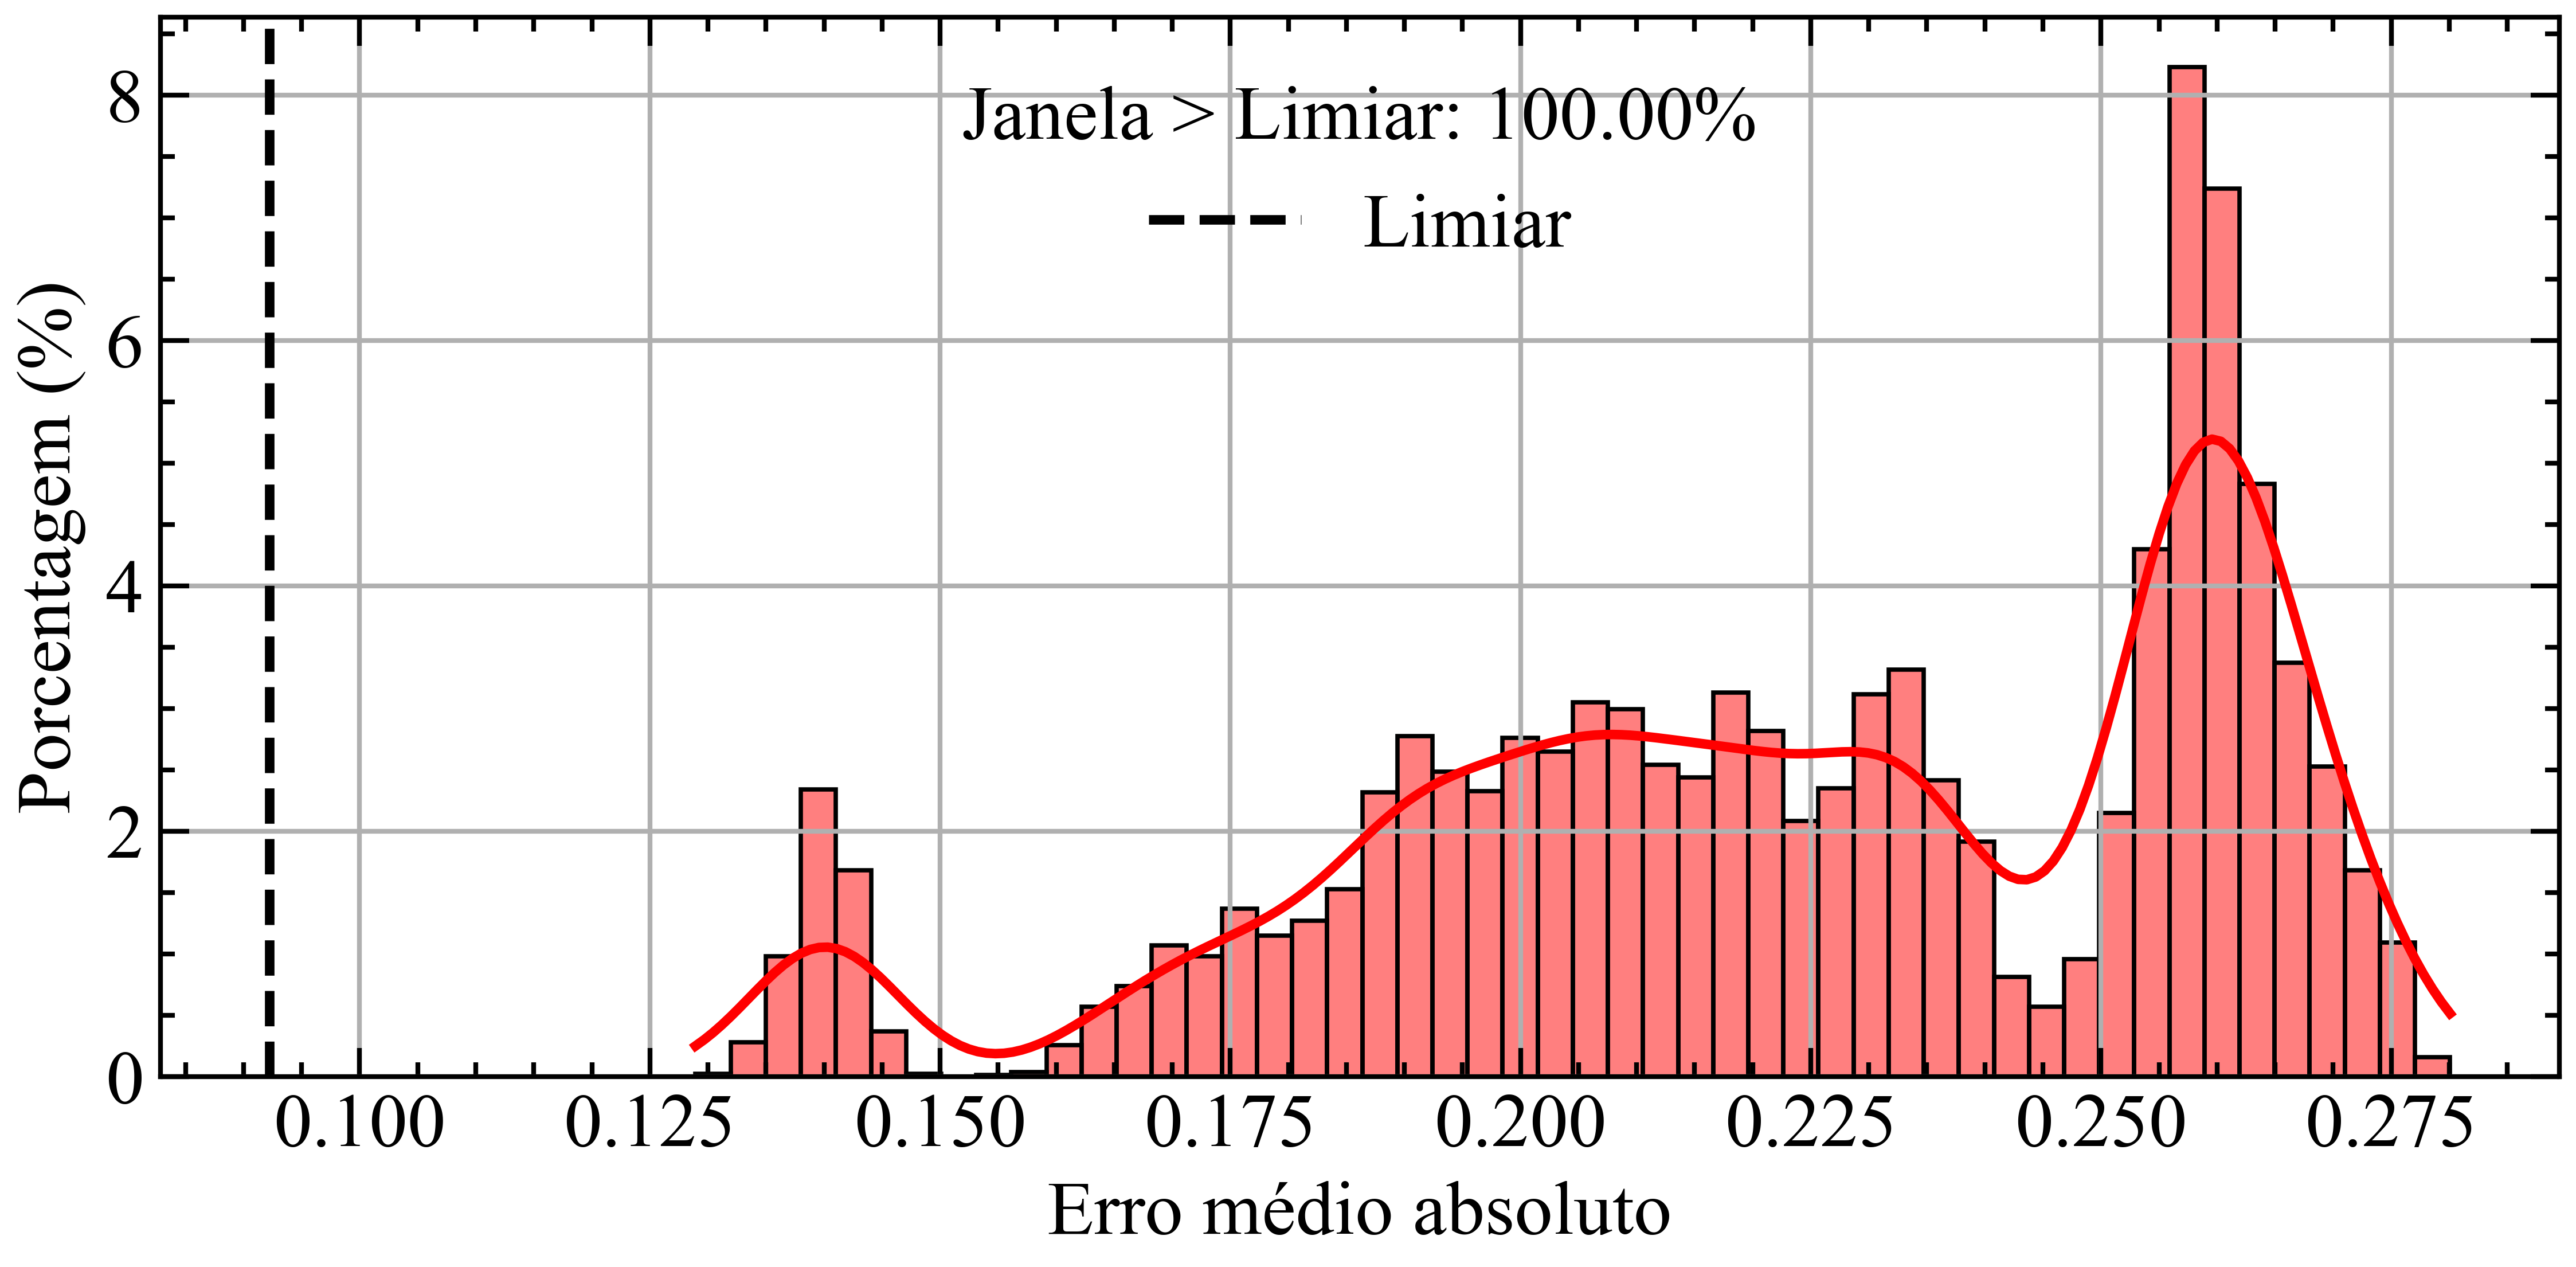

In [10]:
plot_error_dist(errors[0], threshold, "red")

<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

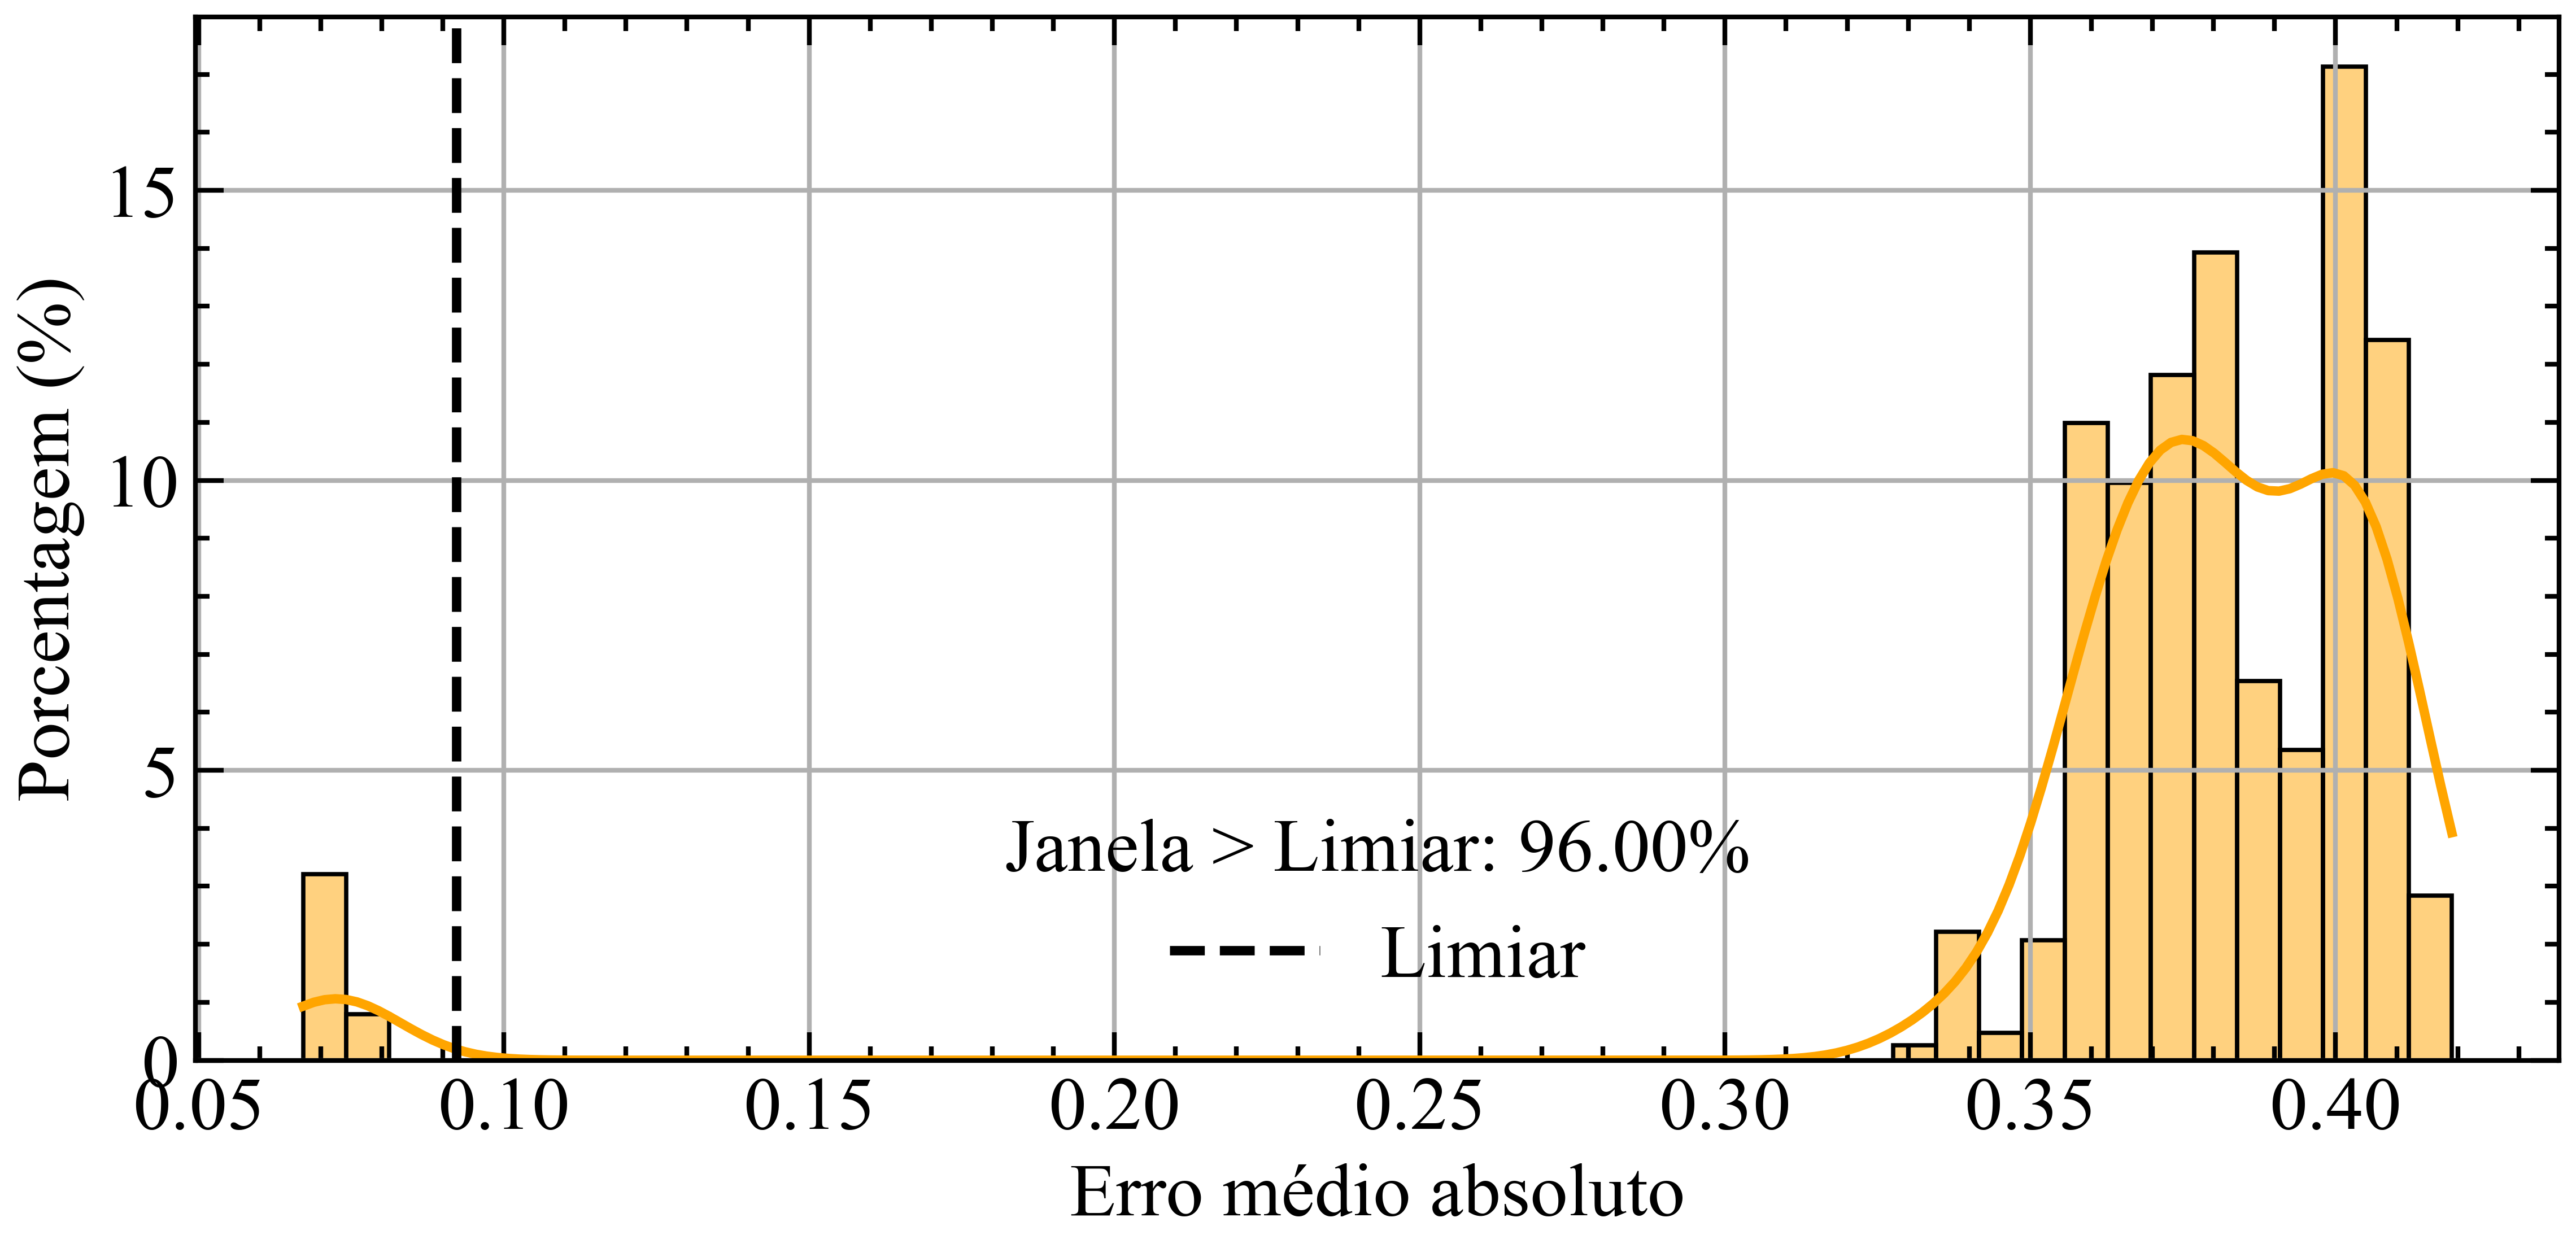

In [11]:
plot_error_dist(errors[1], threshold, "orange")

<Axes: xlabel='Erro médio absoluto', ylabel='Porcentagem (%)'>

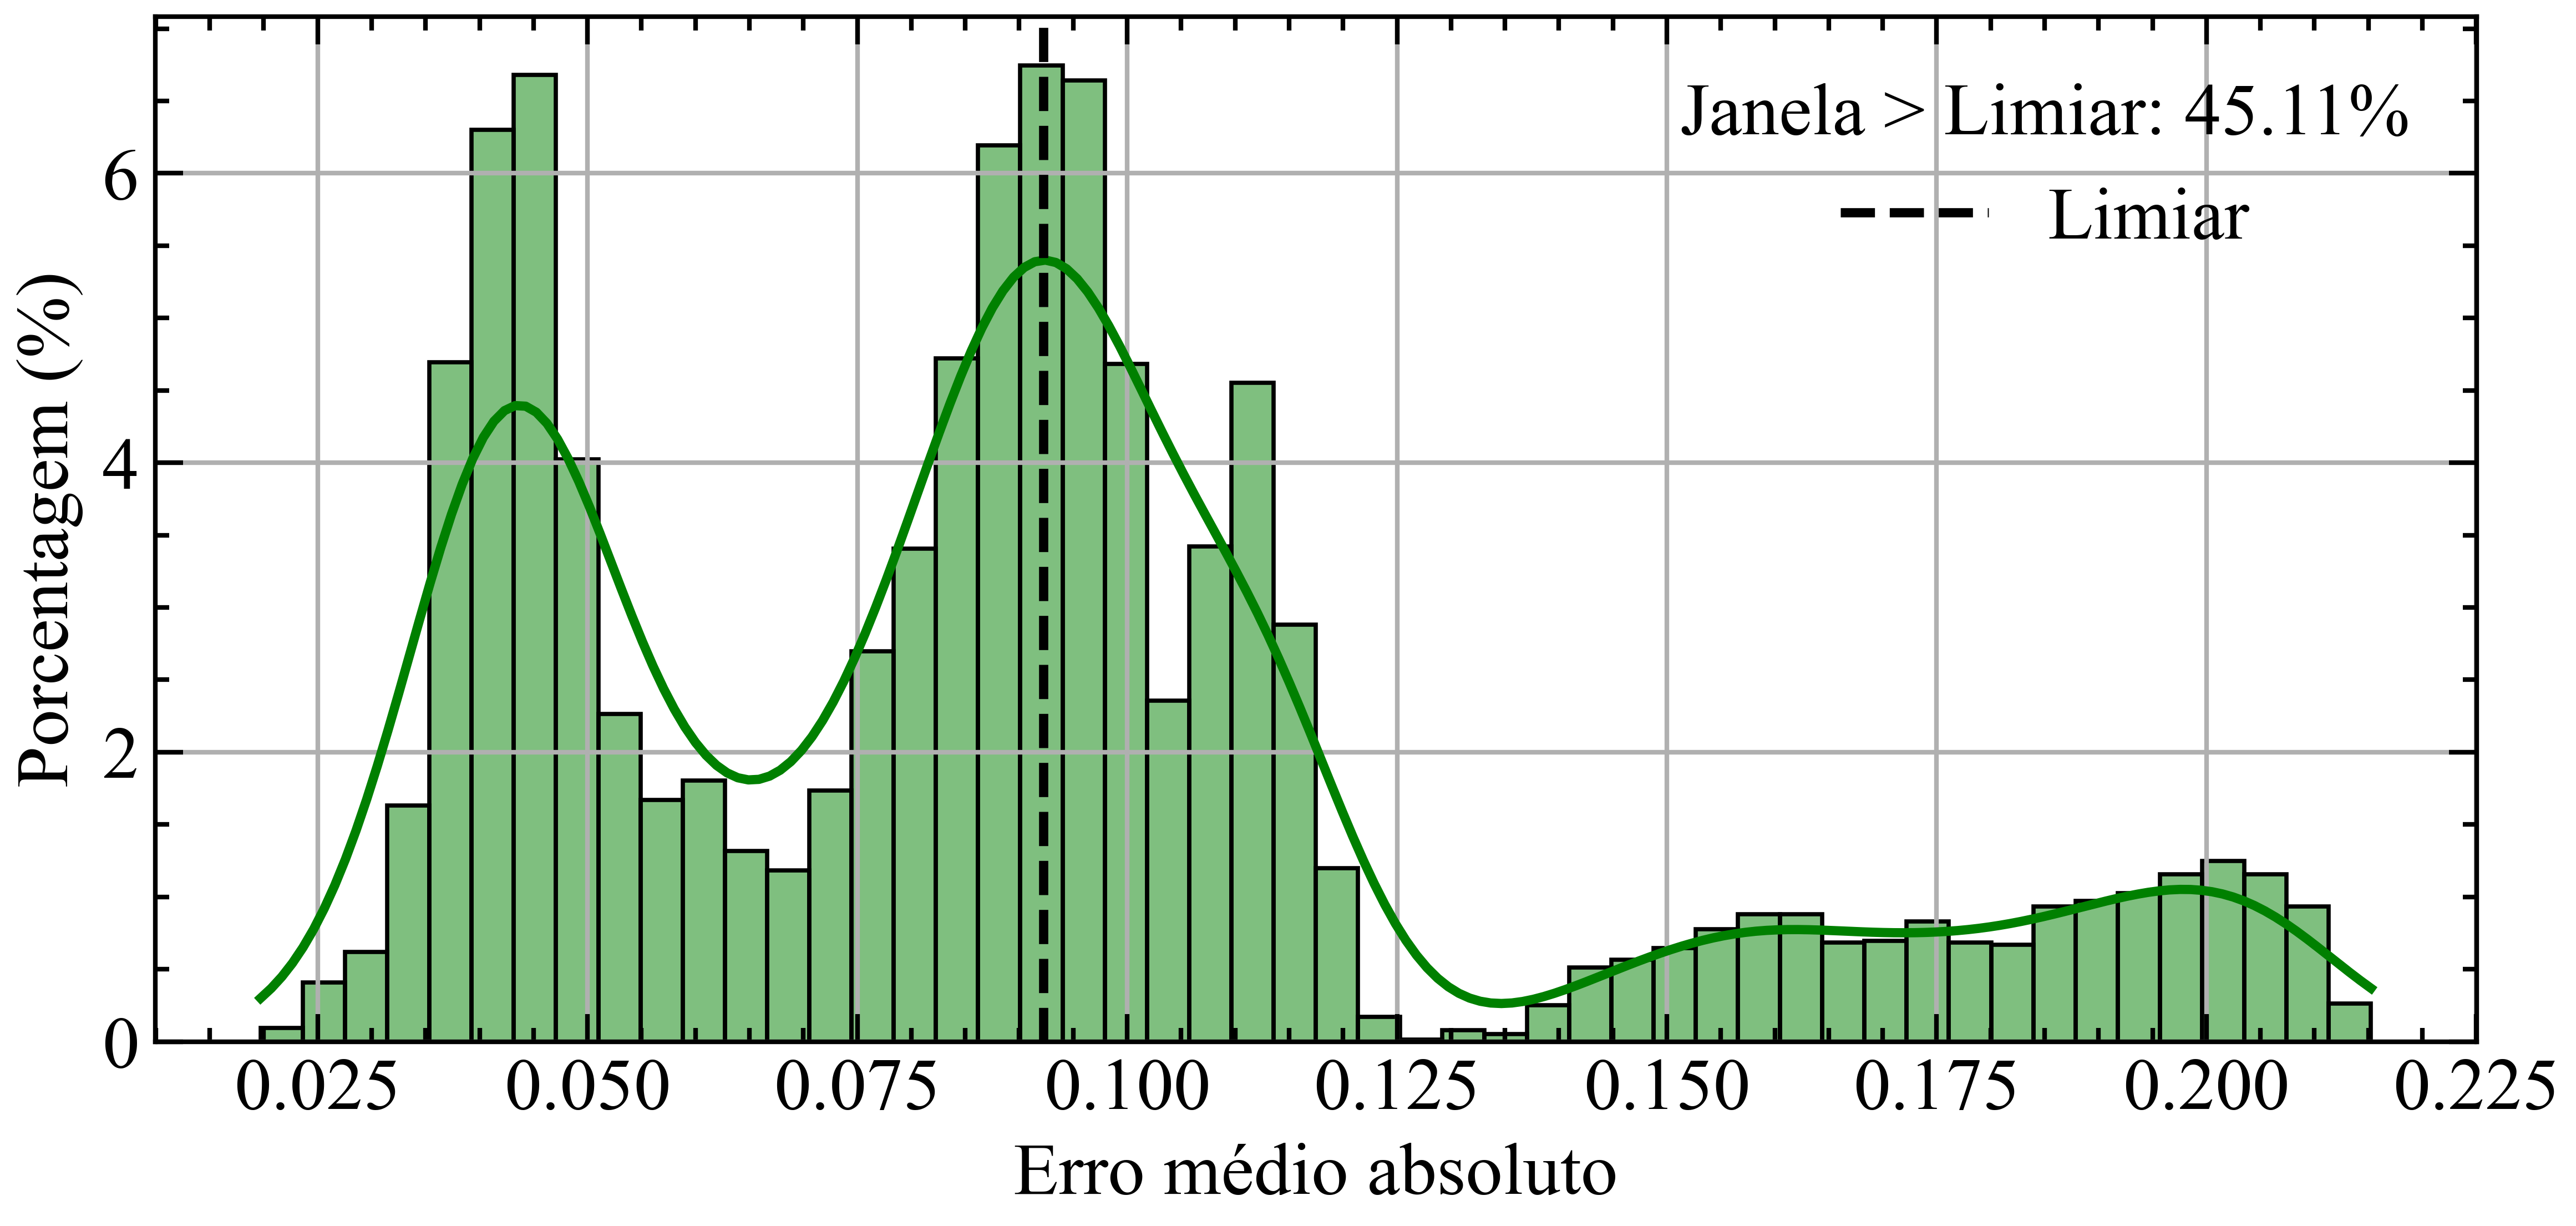

In [12]:
plot_error_dist(errors[3], threshold, "green")

In [13]:
# Exemplo de uso da função
# index: int = 4
# plot_anomalies(anomalies[index], errors[index], threshold)
# plot_anomalies(Yanomalies[3][6000:], errors[3][6000:], threshold)

NameError: name 'transient' is not defined

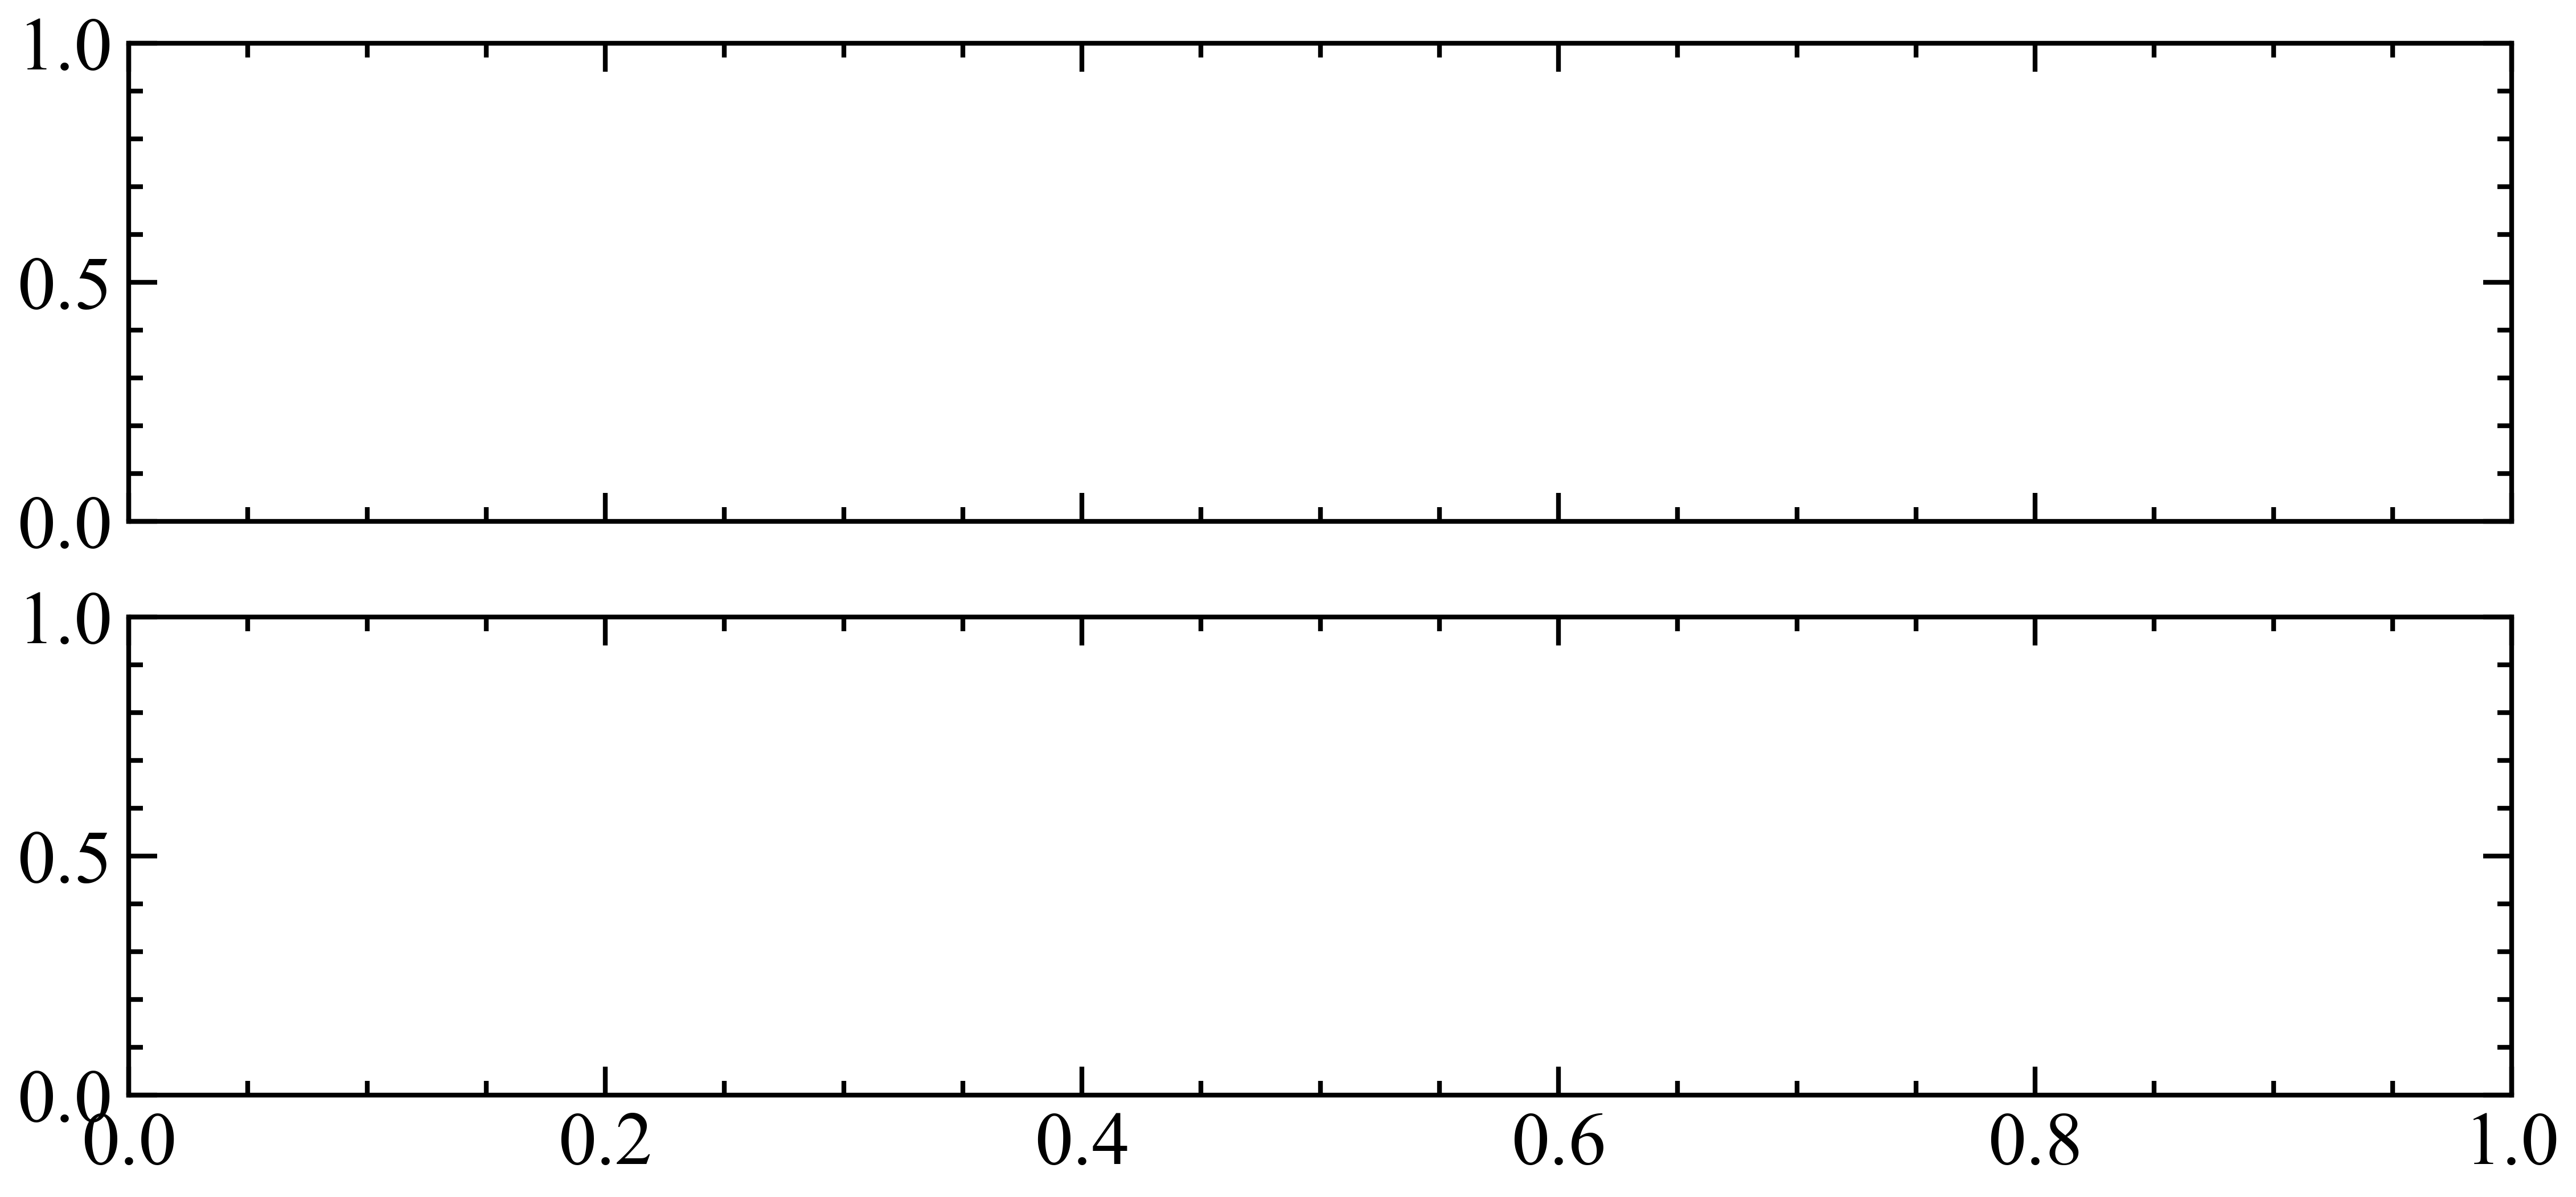

In [14]:
fig, ax = plt.subplots(2,1, sharex=True)

transient_error = get_error_dist(transient)

plot_anomalies(transient, transient_error, threshold, ax=ax[0])
ax[0].set_ylabel(r"$-\Delta$P$_N$")

ax[1].set_ylabel("Erro")
xx = np.arange(len(transient_error)) + DEFAULT_WS
ax[1].plot(xx, transient_error, label="Erro")

ax[1].axhline(threshold, color="red", linestyle="--", label="Limiar")
ax[1].set_xlabel("Instante")
ax[1].legend(loc=1, ncol=2)
ax[0].legend(loc=2)

plt.savefig("../images/anomalies_transiente.png", dpi=300, bbox_inches="tight")

NameError: name 'anomalies' is not defined

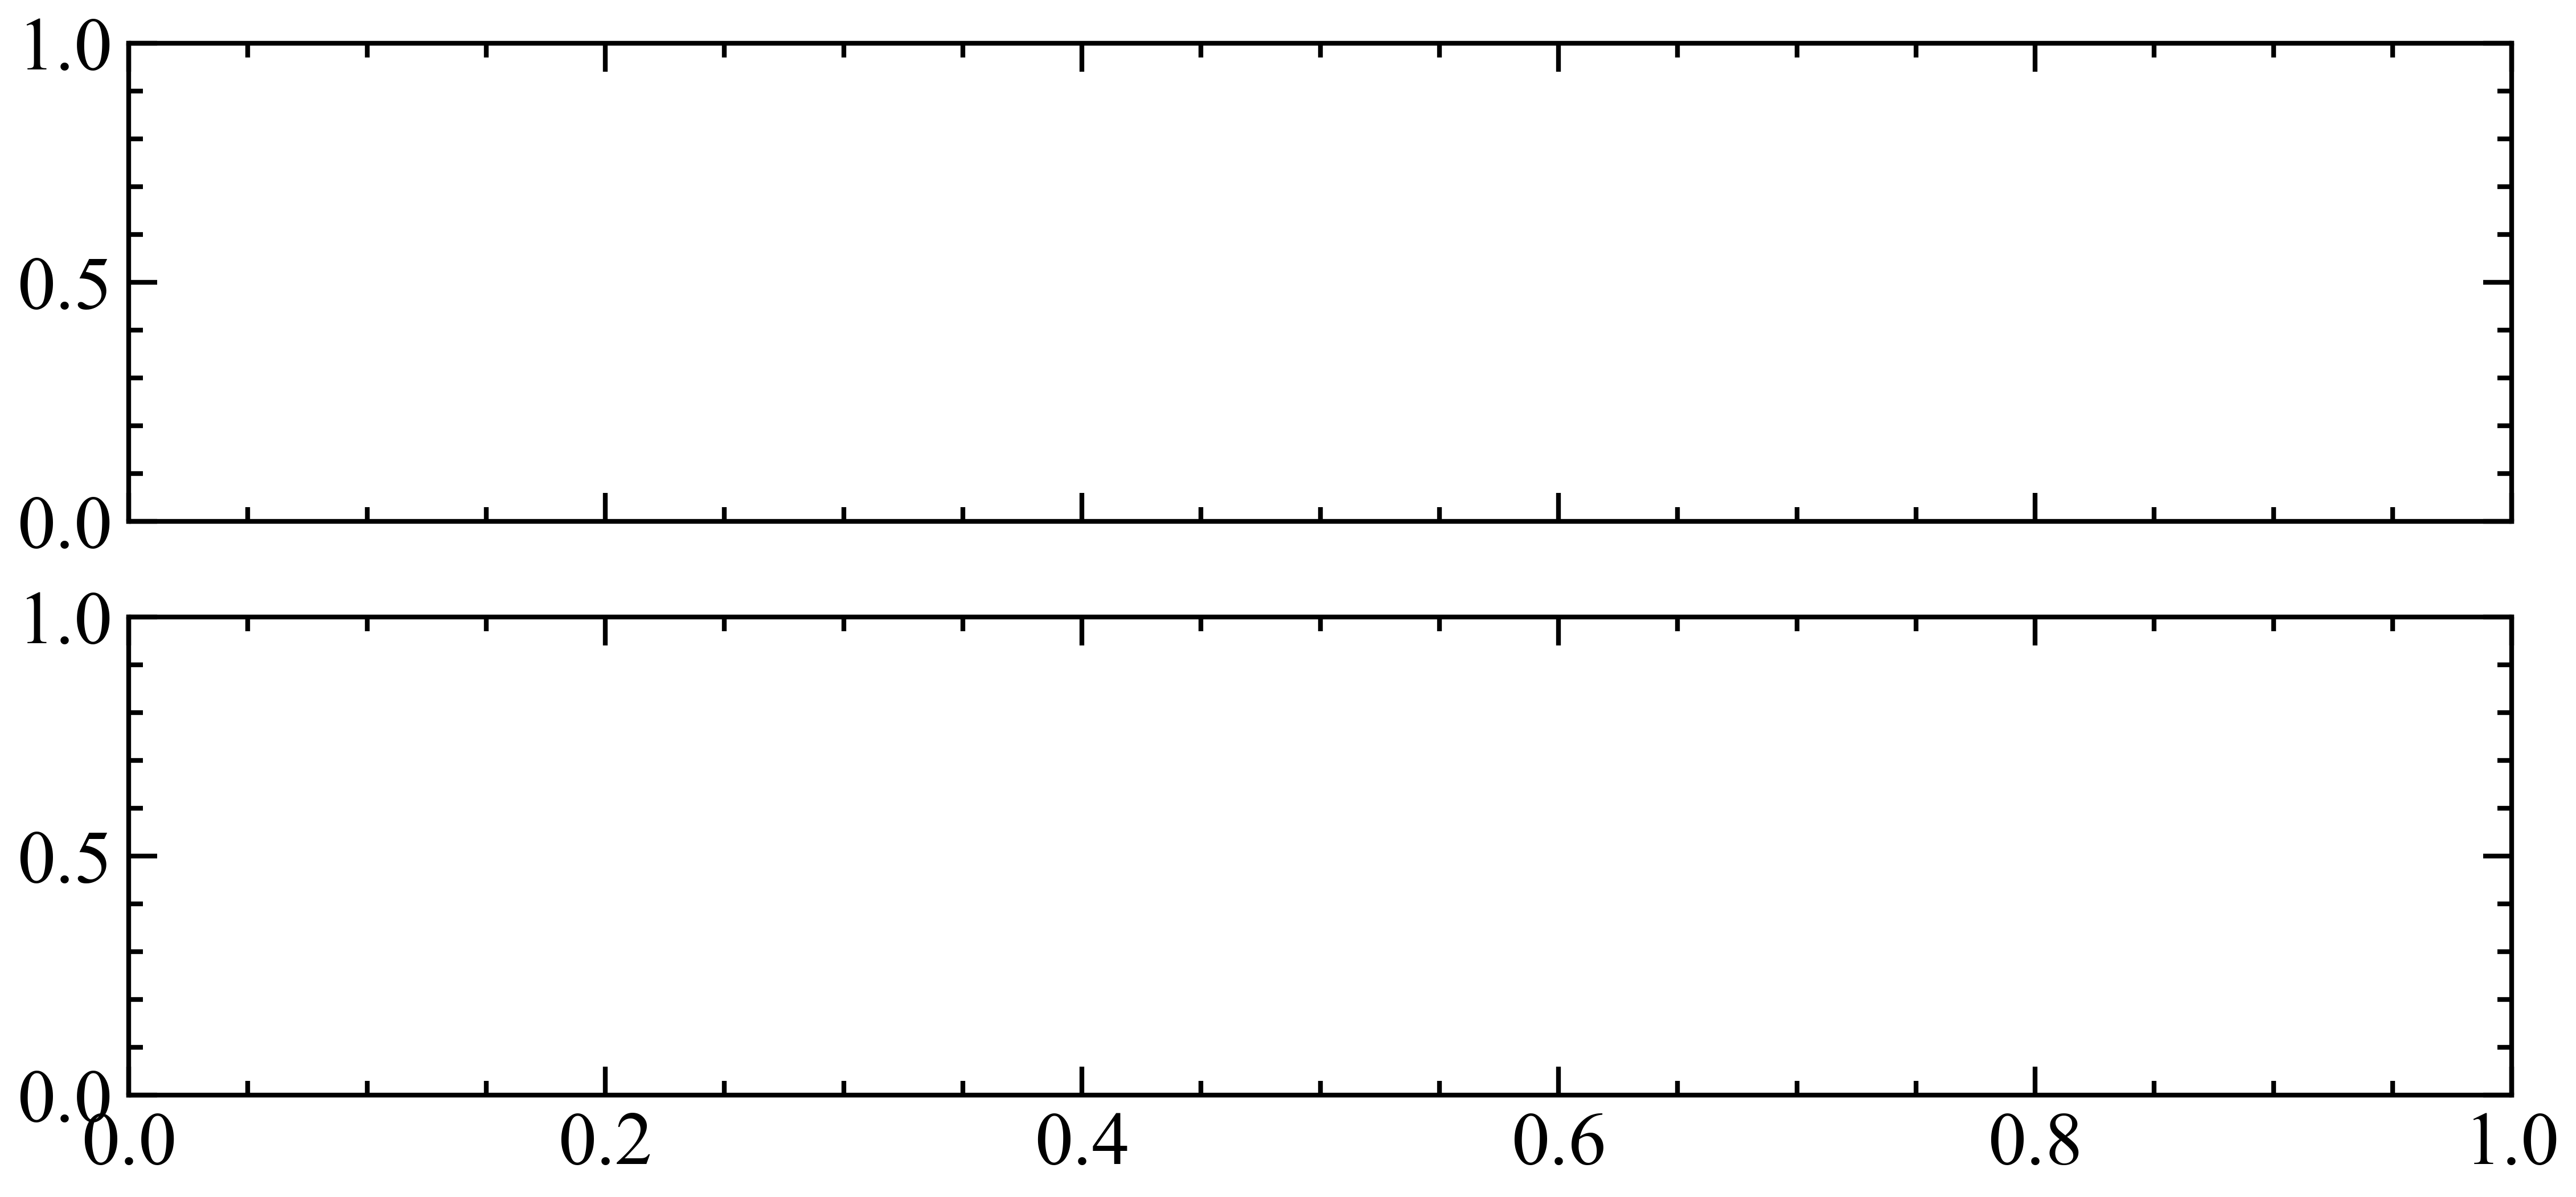

In [15]:
fig, ax = plt.subplots(2,1, sharex=True)

plot_anomalies(anomalies[2], errors[2], threshold, ax=ax[0])
ax[0].set_ylabel(r"$-\Delta$P$_N$")
ax[0].legend(loc=0)

ax[1].set_ylabel("Erro")
xx = np.arange(len(errors[2])) + DEFAULT_WS
ax[1].plot(xx, errors[2], label="Erro")

ax[1].axhline(threshold, color="red", linestyle="--", label="Limiar")
ax[1].set_xlabel("Instante")
ax[1].legend()

plt.savefig("../images/anomalies_painco.png", dpi=300, bbox_inches="tight");

In [ ]:
plot_anomalies(anomalies[2], get_error_dist(anomalies[2]), threshold)

In [20]:
def calculate_thresholds_and_accuracies(
    Xnormal_data: np.ndarray,
    Ynormal_data: np.ndarray,
    Xanomaly_list: list[np.ndarray],
    Yanomaly_list: list[np.ndarray],
    percentiles=[90, 95, 100]
) -> pd.DataFrame:
    """
    Calcula limiares de detecção de anomalias e retorna uma tabela com as acurácias
    """

    normal_errors = get_error_dist(Xnormal_data, Ynormal_data)

    thresholds = {p: np.percentile(normal_errors, p) for p in percentiles}
    accuracies = {p: [] for p in percentiles}

    # Calculate thresholds based on percentiles
    for Xanomaly, Yanomaly in zip(Xanomaly_list, Yanomaly_list):
        anomaly_errors = get_error_dist(Xanomaly, Yanomaly)

        # Calculate accuracy for each threshold
        for p in percentiles:
            threshold = thresholds[p]
            accuracy = get_accuracy(anomaly_errors, threshold)
            accuracies[p].append(accuracy)

    # Create a DataFrame to store the results
    results = pd.DataFrame(
        {
            "Percentil": percentiles,
            "Limiar": [thresholds[p] for p in percentiles],
        }
    )

    anomaly_names = ["A1", "A2", "A3", "A4"]
    for i, name in enumerate(anomaly_names):
        results[f"{name} Acc (%)"] = [
            accuracies[p][i] * 100 for p in percentiles
        ]

    results.set_index("Percentil", inplace=True)
    return results


# Calcular a tabela de limiares e acurácias
results_table = calculate_thresholds_and_accuracies(
    Xnormal, Ynormal, Xanomalies, Yanomalies, percentiles=[90, 95, 99]
)
print(results_table)

1033/1033 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step
ynorm shape: (33031, 20)
ypred shape: (33031, 20)
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
ynorm shape: (8985, 20)
ypred shape: (8985, 20)
271/271 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
ynorm shape: (8665, 20)
ypred shape: (8665, 20)
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step
ynorm shape: (7159, 20)
ypred shape: (7159, 20)
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step
ynorm shape: (7603, 20)
ypred shape: (7603, 20)
             Limiar  A1 Acc (%)  A2 Acc (%)  A3 Acc (%)  A4 Acc (%)
Percentil                                                          
90         0.038018  100.000000  100.000000   88.406202   94.252269
95         0.092215  100.000000   95.995384   76.309540   45.113771
99         0.138132   98.619922   95.995384   65.442101   15.717480


In [ ]:
caption = "Acurácia de detecção de anomalias para diferentes limiares."
position = "H"
label = "tab:acuracias"
header = [
    "Limiar",
    
    "+200g",
    "-200g",
    "Painço",
    "Vidro B2",
]

print(
    results_table.to_latex(
        float_format="%.2f",
        decimal=",",
        caption=caption,
        position=position,
        label=label,
        column_format="c"*(len(Xanomalies) + 1),
        header=header,
    )
)

\begin{table}[H]
\caption{Acurácia de detecção de anomalias para diferentes limiares.}
\label{tab:acuracias}
\begin{tabular}{ccccc}
\toprule
 & Limiar & +200g & -200g & Painço & Vidro B2 \\
Percentil &  &  &  &  &  \\
\midrule
90 & 0,04 & 100,00 & 100,00 & 88,41 & 94,25 \\
95 & 0,09 & 100,00 & 96,00 & 76,31 & 45,11 \\
100 & 0,15 & 94,32 & 96,00 & 65,44 & 14,55 \\
\bottomrule
\end{tabular}
\end{table}

